In [62]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import tushare as ts
import datetime
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA

In [63]:
data = pd.read_csv('./china_gdp.csv')

In [64]:
data

,year,gdp_cap
0,1960,597.16
1,1961,500.57
2,1962,472.09
3,1963,507.07
4,1964,597.08
...,...,...
58,2018,138949.00
59,2019,142800.00
60,2020,146877.00
61,2021,178205.00


In [65]:
gdp_year_data = data.loc[::-1, ['year', 'gdp_cap']]

In [66]:
# gdp_year_data.to_csv('./china_gdp.csv', index=None)
gdp_year_data

,year,gdp_cap
62,2022,179632.00
61,2021,178205.00
60,2020,146877.00
59,2019,142800.00
58,2018,138949.00
...,...,...
4,1964,597.08
3,1963,507.07
2,1962,472.09
1,1961,500.57


In [67]:
gdp_year_data = gdp_year_data.set_index('year')

In [68]:
gdp_year_data

,gdp_cap
year,
2022,179632.00
2021,178205.00
2020,146877.00
2019,142800.00
2018,138949.00
...,...
1964,597.08
1963,507.07
1962,472.09


In [69]:
gdp_series = gdp_year_data['gdp_cap']

In [70]:
gdp_series.head()

year
2022    179632.0
2021    178205.0
2020    146877.0
2019    142800.0
2018    138949.0
Name: gdp_cap, dtype: float64

In [71]:
def test_stationarity(timeseries):
    
    #滑动均值和方差
    rolmean = timeseries.rolling(4).mean()
    rolstd = timeseries.rolling(4).std()

    #绘制滑动统计量
    plt.figure(figsize=(24, 8))   
    orig = plt.plot(timeseries[::10], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #adf检验
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

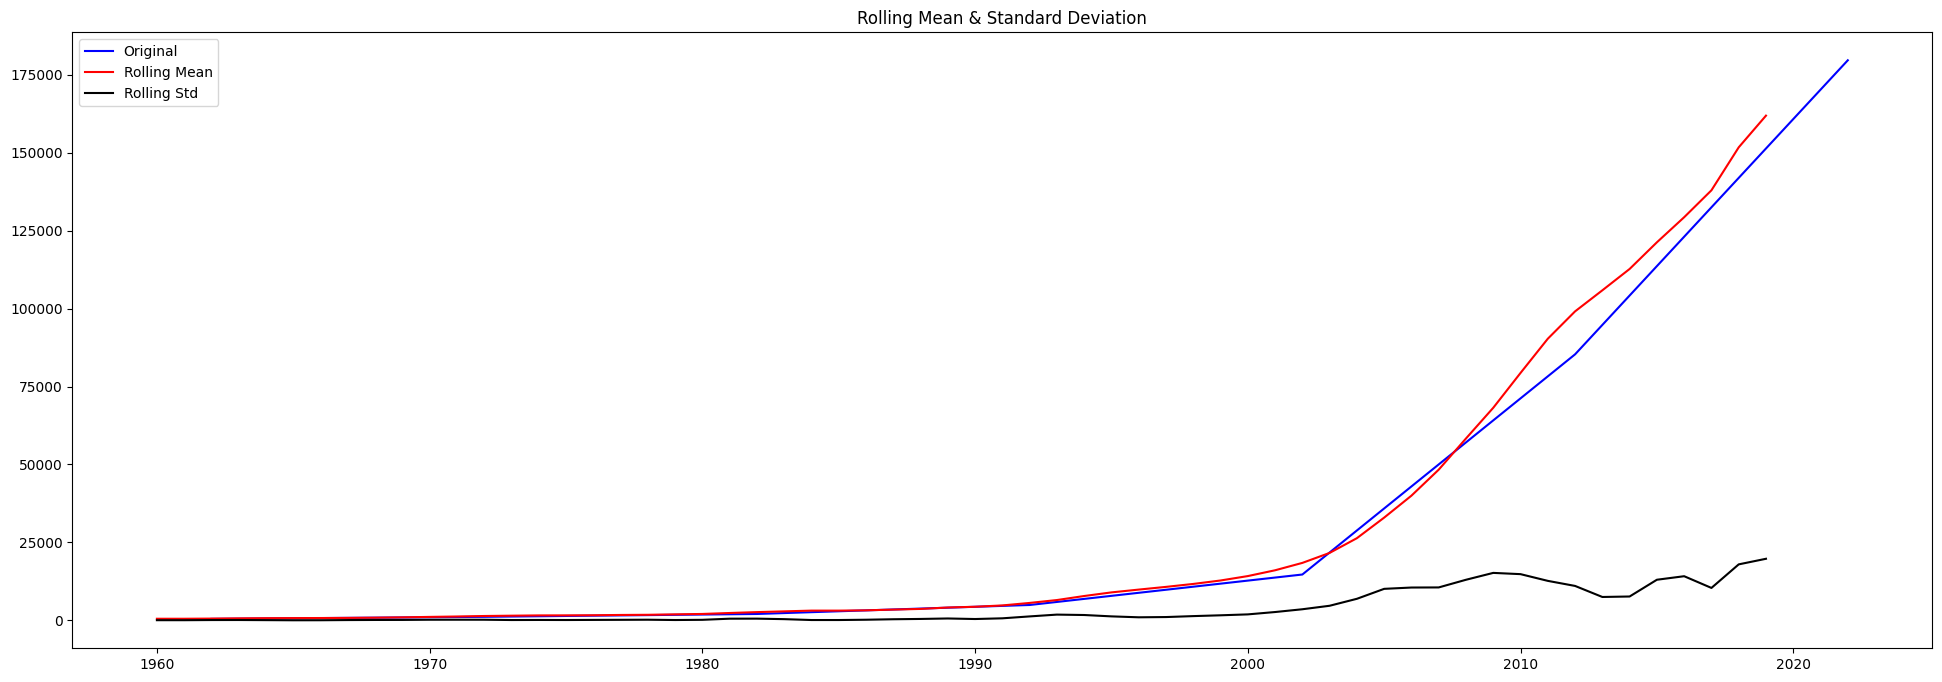

Results of Dickey-Fuller Test:
Test Statistic                -19.324062
p-value                         0.000000
#Lags Used                      9.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


In [72]:
test_stationarity(gdp_series)

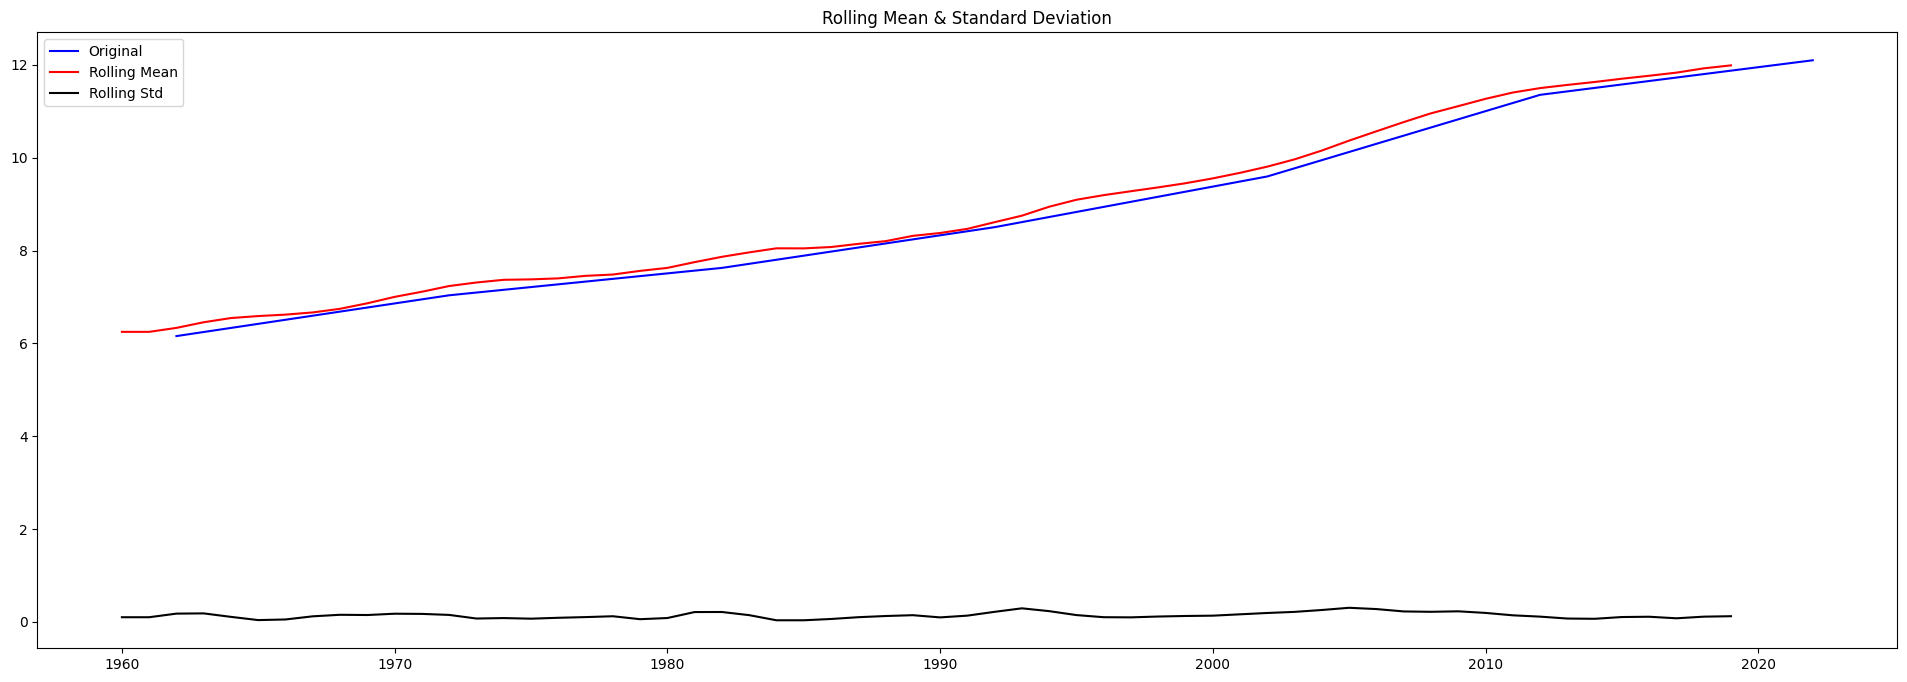

Results of Dickey-Fuller Test:
Test Statistic                 -2.014803
p-value                         0.280120
#Lags Used                      0.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64


In [73]:
# 序列应该是指数函数，因此取log后再检验
gdp_log = np.log(gdp_year_data)
test_stationarity(gdp_log)

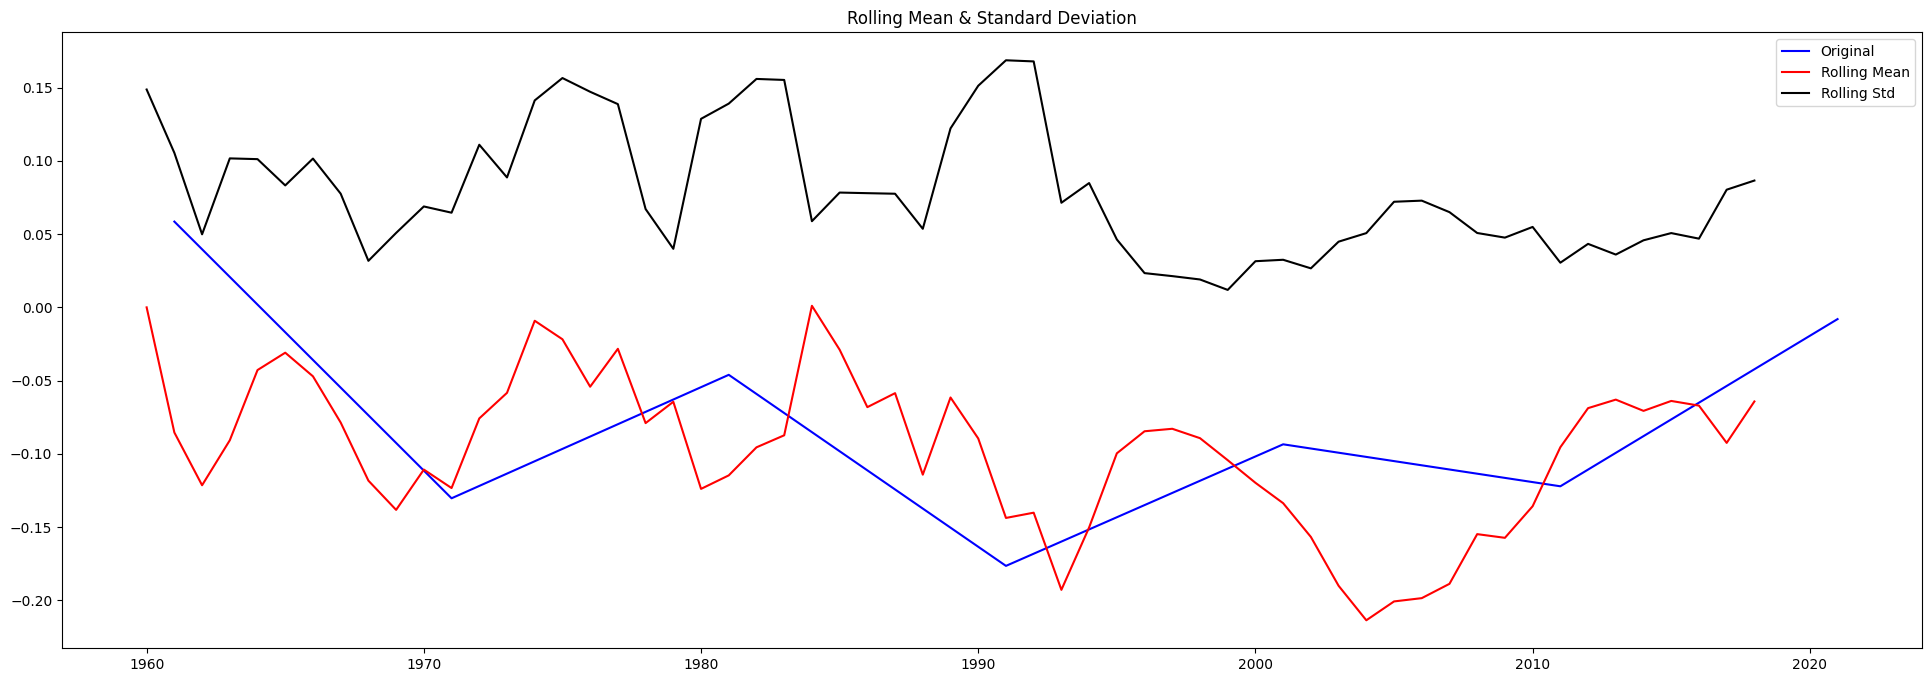

Results of Dickey-Fuller Test:
Test Statistic                -6.349192e+00
p-value                        2.636553e-08
#Lags Used                     0.000000e+00
Number of Observations Used    6.100000e+01
Critical Value (1%)           -3.542413e+00
Critical Value (5%)           -2.910236e+00
Critical Value (10%)          -2.592745e+00
dtype: float64


In [74]:
# 差分
gdp_log_diff = gdp_log.diff(1)
gdp_log_diff.dropna(inplace=True)
test_stationarity(gdp_log_diff)

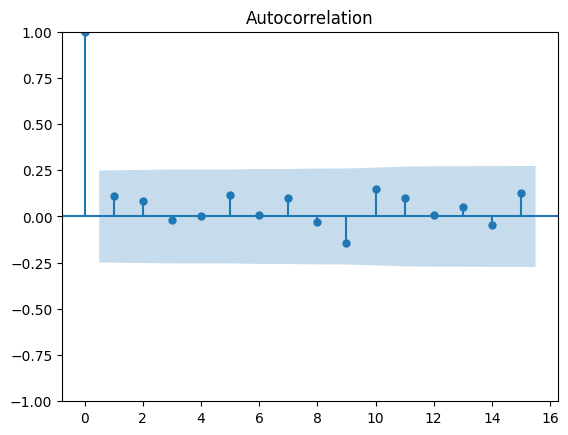

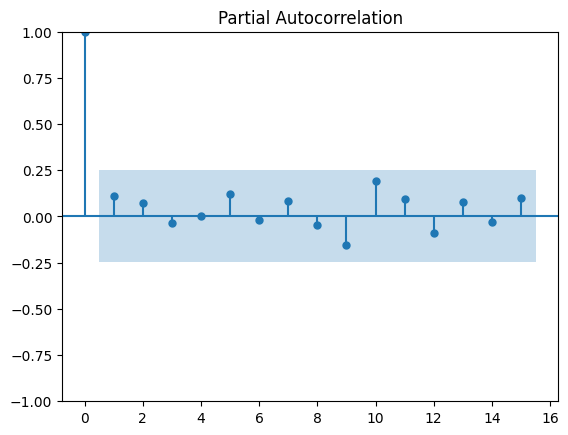

In [75]:
plot_acf(gdp_log_diff, lags=15)
plot_pacf(gdp_log_diff, lags=15)
plt.show()

In [76]:
# 模型定阶主要也有两个方法，一肉眼定阶法和暴力定阶法。肉眼定阶主要是看ACF和PACF，根据拖尾和截尾情况来定阶。
# 暴力定阶法
# AIC）是评估统计模型的复杂度和衡量统计模型“拟合”资料之优良性(Goodness of fit)的一种标准 AIC=2k−2ln(L) k是参数的数量 L是似然函数
# BIC）在不完全情报下，对部分未知的状态用主观概率估计，然后用贝叶斯公式对发生概率进行修正，最后再利用期望值和修正概率做出最优决策
# BIC=ln(n)k–2ln(L) k为模型参数个数 n为样本数量 L为似然函数
# AIC是从预测角度，选择一个好的模型用来预测，BIC是从拟合角度，选择一个对现有数据拟合最好的模型
import statsmodels.tsa.stattools as st
order = st.arma_order_select_ic(gdp_log_diff, max_ar=3, max_ma=3,ic=['aic', 'bic', 'hqic'])
order

c:\Users\ASUS\.conda\envs\torch_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\.conda\envs\torch_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\.conda\envs\torch_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ASUS\.conda\envs\torch_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ASUS\.conda\

{'aic':             0           1           2           3
 0 -108.541607 -107.307669 -106.010306 -104.086237
 1 -107.455355 -105.760262 -104.055244 -102.086383
 2 -105.883347 -103.929703 -105.281856 -101.369168
 3 -103.968398 -101.968532 -100.085187 -101.623037,
 'bic':             0           1          2          3
 0 -104.287338 -100.926266 -97.501769 -93.450565
 1 -101.073952  -97.251725 -93.419572 -89.323577
 2  -97.374810  -93.294031 -92.519049 -86.479227
 3  -93.332726  -89.205726 -85.195247 -84.605962,
 'hqic':             0           1           2          3
 0 -106.871274 -104.802169 -102.669640 -99.910404
 1 -104.949856 -102.419596  -99.879411 -97.075383
 2 -102.542681  -99.753870 -100.270856 -95.523001
 3  -99.792565  -96.957532  -94.239021 -94.941704,
 'aic_min_order': (0, 0),
 'bic_min_order': (0, 0),
 'hqic_min_order': (0, 0)}

In [78]:
model = ARMA(gdp_log_diff, (0, 0)).fit()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


如果残差是白噪声序列，说明时间序列中有用的信息已经被提取完毕了，剩下的全是随机扰动，是无法预测和使用的。

残差序列如果通过了白噪声检验，则建模就可以终止了，因为没有信息可以继续提取。如果残差如果未通过白噪声检验，
说明残差中还有有用的信息，需要修改模型或者进一步提取